# Ceramic Microstructure Processing

## Python packages

In [41]:
from typing import List, Tuple
import random
import numpy as np
import time
import numba
from skimage import morphology
from skimage.color import label2rgb
import matplotlib.pyplot as plt
import h5py
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms
from torchvision.transforms import ToTensor, Compose, ToTensor, Normalize, Grayscale, RandomRotation, Resize, RandomGrayscale
import os
from PIL import Image
import torch.optim as optim
from itertools import product
from torchvision.utils import make_grid

## Dataset

In [2]:
f=h5py.File("/Users/nikolai/Desktop/pure_iron_grain_data_sets.hdf5", "r")
images = f['image']
images=np.moveaxis(images,2,0)
labels = f['label']
labels=np.moveaxis(labels,2,0)
boundaries = f['boundary']
boundaries=np.moveaxis(boundaries,2,0)
print(images.shape,labels.shape,boundaries.shape)

(296, 1024, 1024) (296, 1024, 1024) (296, 1024, 1024)


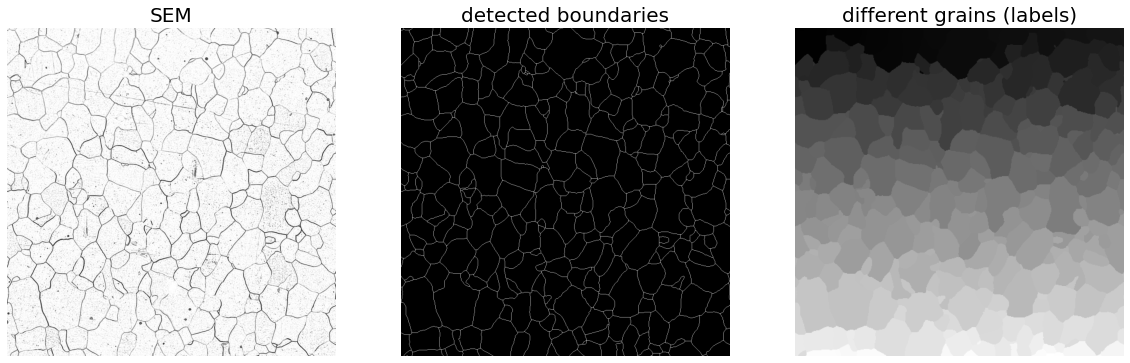

In [3]:
plt.figure(figsize=(20, 20))
plt.subplot(131)
plt.imshow(images[0],cmap='gray')
plt.axis('off')
plt.title("SEM", fontsize=20)
plt.subplot(132)
plt.imshow(boundaries[0],cmap='gray')
plt.axis('off')
plt.title("detected boundaries", fontsize=20)
plt.subplot(133)
plt.imshow(labels[0],cmap='gray')
plt.axis('off')
plt.title("different grains (labels)", fontsize=20)
plt.show()

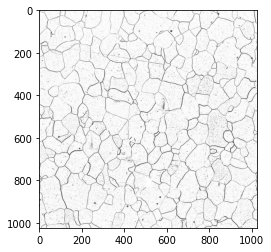

In [4]:
plt.imshow(images[0],cmap='gray')
#[plt.imsave(f'Im_Iron/Im_{i}.jpeg', images[i],cmap='gray') for i in range(len(images))]
print()

#### Cutting source pictures

In [5]:
def crop(img: Tuple[float, float], image_size: int) -> Tuple[float, float, float]:
    """Crop images by certain size"""
    
    k: int = 0  # counter
    w, h = img.shape  # weight and height of original image
    NO_CELLS: int = int(w / image_size)  # number of images in line of original image
    images_matrix = np.zeros((int(h / image_size)* int(w / image_size),
                              image_size, image_size))  # empty matrix for new images
    grid = product(range(0, h, image_size), range(0, w, image_size)) # grid to extract new images
    for i, j in grid:
        images_matrix[k] = img[j: j + image_size, i: i + image_size]
        k += 1
    return images_matrix

image_size = 128
for i, image in enumerate(images):
    if i == 0:
        croped_images = crop(image, image_size)
    else:
        croped_images = np.concatenate((croped_images, crop(image, image_size)))

print(croped_images.shape)

(18944, 128, 128)


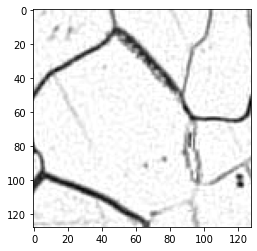

In [6]:
plt.imshow(croped_images[7577],cmap='gray')

In [25]:
class SEM_Dataset(Dataset):
    def __init__(self, images):#, labels, boundaries):
        self.images = [torch.Tensor(i) for i in croped_images]
        #self.boundaries = [torch.Tensor(i) for i in boundaries]
        #self.labels = [torch.Tensor(i) for i in labels]
        #self.transform = Compose([RandomRotation(degrees=(-179, 179)),
        #                          Grayscale(num_output_channels=1)
        #                         ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image=self.images[idx]
        image=image.reshape(-1,image.shape[0],image.shape[1])
        #image=self.transform(image)
        #boundary=self.boundaries[idx]
        #label=self.labels[idx]
        return image#, boundary, label
    
SEM_images = SEM_Dataset(images)#, boundaries, labels)

## GAN

#### Generator and Discriminator

In [8]:
class Generator(nn.Module):
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4, kernel_size = 8),  # [8, 10, 1, 1] -> [8, 1, 8, 8]
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2),  # [8, 1, 8, 8] -> [8, 1, 16, 16]
            self.make_gen_block(hidden_dim * 2, hidden_dim),  # [8, 1, 16, 16] -> [8, 1, 32, 32]
            self.make_gen_block(hidden_dim, im_chan),  # [8, 1, 32, 32] -> [8, 1, 64, 64]
            self.make_gen_block(im_chan, im_chan, final_layer=True),  # [8, 1, 64, 64] -> [8, 1, 128, 128]
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=2, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels=input_channels,
                                   out_channels=output_channels,
                                   kernel_size=kernel_size,
                                   stride=stride,
                                   padding=0),
                nn.BatchNorm2d(num_features=output_channels),
                nn.ReLU()
            )
        else: # Final Layer
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels=input_channels,
                                   out_channels=output_channels,
                                   kernel_size=kernel_size,
                                   stride=stride,
                                   padding=0),
                nn.Tanh()
            )
            
    def unsqueeze_noise(self, noise):
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        x = self.unsqueeze_noise(noise)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples, z_dim, device=device)

In [306]:
def make_gen_block(input_channels, output_channels, kernel_size=2, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels=input_channels,
                                   out_channels=output_channels,
                                   kernel_size=kernel_size,
                                   stride=stride,
                                   padding=0),
                nn.BatchNorm2d(num_features=output_channels),
                nn.ReLU()
            )
        else: # Final Layer
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels=input_channels,
                                   out_channels=output_channels,
                                   kernel_size=kernel_size,
                                   stride=stride,
                                   padding=0),
                nn.Tanh()
            )
            
def unsqueeze_noise(noise):
    return noise.view(len(noise), z_dim, 1, 1)
z_dim = 10
gen = nn.Sequential(
            make_gen_block(z_dim, hidden_dim * 4, kernel_size = 4),  # [8, 10, 1, 1] -> [8, 1, 8, 8]
            make_gen_block(hidden_dim * 8, hidden_dim * 4),  # [8, 1, 8, 8] -> [8, 1, 16, 16]
            make_gen_block(hidden_dim * 4, hidden_dim*2),  # [8, 1, 16, 16] -> [8, 1, 32, 32]
            make_gen_block(hidden_dim * 2, im_chan, final_layer=False),  # [8, 1, 32, 32] -> [8, 1, 64, 64]
            make_gen_block(hidden_dim, im_chan, final_layer=True),  # [8, 1, 64, 64] -> [8, 1, 128, 128]
        )
block1 = nn.Sequential(make_gen_block(z_dim, hidden_dim * 4, kernel_size = 8))  # [8, 10, 1, 1] -> [8, 1, 8, 8]
block2 = nn.Sequential(make_gen_block(hidden_dim * 4, hidden_dim * 2))  # [8, 1, 8, 8] -> [8, 1, 16, 16]
block3 = nn.Sequential(make_gen_block(hidden_dim * 2, hidden_dim))  # [8, 1, 16, 16] -> [8, 1, 32, 32]
block4 = nn.Sequential(make_gen_block(hidden_dim , im_chan, final_layer=False))  # [8, 1, 32, 32] -> [8, 1, 64, 64]
block5 = nn.Sequential(make_gen_block(im_chan, im_chan, final_layer=True))  # [8, 1, 64, 64] -> [8, 1, 128, 128]
n_samples=8
noise = get_noise(n_samples, z_dim)
noise = unsqueeze_noise(noise)

im = block1(noise)
print(im.shape)
im = block2(im)
print(im.shape)
im = block3(im)
print(im.shape)
im = block4(im)
print(im.shape)
im = block5(im)
print(im.shape)

torch.Size([8, 512, 8, 8])
torch.Size([8, 256, 16, 16])
torch.Size([8, 128, 32, 32])
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 128, 128])


In [29]:
class Discriminator(nn.Module):
    def __init__(self, im_chan=1, hidden_dim=30):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),  # [8, 1, 128, 128] -> [8, 16, 64, 64]
            self.make_disc_block(hidden_dim, hidden_dim * 2, final_layer=False),  # [8, 16, 64, 64] -> [8, 32, 32, 32]
            self.make_disc_block(hidden_dim * 2, hidden_dim * 4, final_layer=False),  # [8, 60, 32, 32] -> [8, 120, 16, 16]
            self.make_disc_block(hidden_dim * 4, hidden_dim * 8, final_layer=False),  # [8, 120, 16, 16] -> [8, 240, 8, 8]
            self.make_disc_block(hidden_dim * 8, hidden_dim * 16, final_layer=False),  # [8, 240, 8, 8] -> [8, 480, 4, 4]
            self.make_disc_block(hidden_dim * 16, hidden_dim * 32, final_layer=True)  # [8, 480, 4, 4] -> [8, 960, 2, 2]
        
        )
        self.lin = torch.nn.Linear(3840, 1)  # [8, 3840] -> [8, 1]
        self.sig = nn.Sigmoid()
        
    def make_disc_block(self, input_channels, output_channels, kernel_size=3, stride=1, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(in_channels=input_channels,
                          out_channels=output_channels,
                          kernel_size=kernel_size,
                          stride=stride),
                nn.BatchNorm2d(output_channels),
                nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
                nn.Dropout(p=0.2),
                nn.LeakyReLU(0.2)
            )
        else: # Final Layer
            return nn.Sequential(
                nn.Conv2d(in_channels=input_channels,
                          out_channels=output_channels,
                          kernel_size=kernel_size,
                          stride=stride)
            )

    def forward(self, image):
        disc_pred = self.disc(image)
        disc_pred = disc_pred.view(len(disc_pred), -1)  # [8, 960, 2, 2] -> [8, 3840]
        disc_pred = self.lin(disc_pred)
        return self.sig(disc_pred)

In [21]:
def make_disc_block(input_channels, output_channels, kernel_size=3, stride=1, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(in_channels=input_channels,
                          out_channels=output_channels,
                          kernel_size=kernel_size,
                          stride=stride),
                nn.BatchNorm2d(output_channels),
                nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
                nn.Dropout(p=0.2),
                nn.LeakyReLU(0.2)
            )
        else: # Final Layer
            return nn.Sequential(
                nn.Conv2d(in_channels=input_channels,
                          out_channels=output_channels,
                          kernel_size=kernel_size,
                          stride=stride)
            )

im_chan=1
hidden_dim=30

disc = nn.Sequential(
            make_disc_block(im_chan, hidden_dim),
            make_disc_block(hidden_dim, hidden_dim * 2, final_layer=True),
            #make_disc_block(hidden_dim * 2, 1, final_layer=True),
            )
lin = torch.nn.Linear(3840, 1)
sig = nn.Sigmoid()



fake = torch.randn(8, 1, 128, 128)
block1 = make_disc_block(im_chan, hidden_dim)  # [8, 1, 128, 128] -> [8, 30, 64, 64]
fake = block1(fake)
print(fake.shape)
block2 = make_disc_block(hidden_dim, hidden_dim * 2, final_layer=False)  # [8, 30, 64, 64] -> [8, 60, 32, 32]
fake = block2(fake)
print(fake.shape)
block3 = make_disc_block(hidden_dim * 2, hidden_dim * 4, final_layer=False)  # [8, 60, 32, 32] -> [8, 120, 16, 16]
fake = block3(fake)
print(fake.shape)
block4 = make_disc_block(hidden_dim * 4, hidden_dim * 8, final_layer=False)  # [8, 120, 16, 16] -> [8, 240, 8, 8]
fake = block4(fake)
print(fake.shape)
block5 = make_disc_block(hidden_dim * 8, hidden_dim * 16, final_layer=False)  # [8, 240, 8, 8] -> [8, 480, 4, 4]
fake = block5(fake)
print(fake.shape)
block6 = make_disc_block(hidden_dim * 16, hidden_dim * 32, final_layer=True)  # [8, 480, 4, 4] -> [8, 960, 2, 2]
fake = block6(fake)
print(fake.shape)
fake = torch.flatten(fake, start_dim = 1)  # [batch, 960, 2, 2] -> [batch, 3840]
print(fake.shape)
fake = lin(fake)  # [8, 3840] -> [8, 1]
print(fake.shape)

torch.Size([8, 30, 64, 64])
torch.Size([8, 60, 32, 32])
torch.Size([8, 120, 16, 16])
torch.Size([8, 240, 8, 8])
torch.Size([8, 480, 4, 4])
torch.Size([8, 960, 2, 2])
torch.Size([8, 3840])
torch.Size([8, 1])


In [23]:
from torchvision.datasets import MNIST
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])
dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=8,
    shuffle=True)

In [24]:
for i, real in enumerate(dataloader):
    print(real[0].shape)
    break

torch.Size([8, 1, 28, 28])


### DCGAN

In [44]:
z_dim = 20
display_step = 500
batch_size=8

train_loader=DataLoader(dataset=SEM_images, batch_size=batch_size, shuffle=True)

criterion = nn.BCEWithLogitsLoss()
lr = 0.001
beta_1 = 0.5 
beta_2 = 0.999

device = 'cpu'

gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

# initialize the weights to the normal distribution
# with mean 0 and standard deviation 0.02
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0, 0.02)
        torch.nn.init.constant_(m.bias, 1)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

In [45]:
n_epochs = 10
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0

t0 = time.time()

gen_loss_list = []
disc_loss_list = []
for epoch in range(n_epochs):
    # Dataloader returns the batches
    for i, real in enumerate(train_loader):
        #real=real[0]

        ## Update discriminator ##
        
        fake_noise = get_noise(batch_size, z_dim)
        fake = gen(fake_noise)
        disc_fake_pred = disc(fake)#.detach())
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_pred = disc(real)
        print(disc_real_pred)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step
        # Update gradients
        disc_loss.backward(retain_graph=True)
        # Update optimizer
        disc_opt.step()
        disc_opt.zero_grad()

        ## Update generator ##
        
        #fake_noise = get_noise(batch_size, z_dim)
        #fake = gen(fake_noise)
        disc_fake_pred = disc(fake)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()
        gen_opt.zero_grad()

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ## Visualization code ##
        t1 = (time.time() - t0) / 60
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Epoch {epoch}, step {cur_step}: "+ 
                  f"Generator loss: {mean_generator_loss}, "+ 
                  f"discriminator loss: {mean_discriminator_loss}, "+
                  f"time: {t1} min")
            fix, axs = plt.subplots(ncols=2)
            axs[0].imshow(fake[0][0].detach().numpy(),cmap='gray')
            axs[0].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
            axs[1].imshow(real[0][0].detach().numpy(),cmap='gray')
            axs[1].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
            plt.show()
            gen_loss_list.append(mean_generator_loss)
            disc_loss_list.append(mean_discriminator_loss)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1

tensor([[0.2566],
        [0.2128],
        [0.1410],
        [0.2151],
        [0.1453],
        [0.1032],
        [0.1667],
        [0.1693]], grad_fn=<SigmoidBackward0>)
tensor([[2.3500e-24],
        [4.2318e-24],
        [2.1065e-24],
        [2.2704e-24],
        [3.0529e-24],
        [3.2623e-24],
        [1.1211e-24],
        [5.0441e-24]], grad_fn=<SigmoidBackward0>)
tensor([[3.8839e-35],
        [4.1532e-35],
        [3.9254e-35],
        [2.0587e-35],
        [1.2270e-35],
        [1.3399e-35],
        [1.6820e-35],
        [7.2335e-35]], grad_fn=<SigmoidBackward0>)
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], grad_fn=<SigmoidBackward0>)
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], grad_fn=<SigmoidBackward0>)
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], grad_fn=<SigmoidBackwa

[E thread_pool.cpp:113] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:113] Exception in thread pool task: mutex lock failed: Invalid argument


KeyboardInterrupt: 

In [ ]:
torch.save(gen.state_dict(), "./gen_weights.pth")
torch.save(disc.state_dict(), "./disc_weights.pth")
gen.load_state_dict(torch.load("./gen_weights.pth"))
disc.load_state_dict(torch.load("./disc_weights.pth"))

### WGAN

#### Wasserstein Losses

In [ ]:
def get_gradient(disc, real, fake, epsilon):
    '''
    Return the gradient of the discriminator's scores with respect to mixes of real and fake images.
    Parameters:
        disc: the discriminator model
        real: a batch of real images
        fake: a batch of fake images
        epsilon: a vector of the uniformly random proportions of real/fake per mixed image
    Returns:
        gradient: the gradient of the discriminator's scores, with respect to the mixed image
    '''
    mixed_images = real * epsilon + fake * (1 - epsilon)  # Mix the images together
    mixed_scores = disc(mixed_images)  # Calculate the discriminator's scores on the mixed images
    
    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=mixed_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores), 
        create_graph=True,
        retain_graph=True,
    )[0]
    return gradient

In [ ]:
def gradient_penalty(gradient):
    '''
    Return the gradient penalty, given a gradient.
    Given a batch of image gradients, you calculate the magnitude of each image's gradient
    and penalize the mean quadratic distance of each magnitude to 1.
    Parameters:
        gradient: the gradient of the critic's scores, with respect to the mixed image
    Returns:
        penalty: the gradient penalty
    '''
    gradient = gradient.view(len(gradient), -1)  # Flatten the gradients so that each row captures one image
    gradient_norm = gradient.norm(2, dim=1)  # Calculate the magnitude of every row
    # Penalize the mean squared distance of the gradient norms from 1
    penalty = ((gradient_norm-1)**2).mean()
    return penalty

In [ ]:
def get_gen_loss(disc_fake_pred):
    '''
    Return the loss of a generator given the critic's scores of the generator's fake images.
    Parameters:
        crit_fake_pred: the critic's scores of the fake images
    Returns:
        gen_loss: a scalar loss value for the current batch of the generator
    '''
    gen_loss = -disc_fake_pred.mean()
    return gen_loss

In [ ]:
def get_disc_loss(disc_fake_pred, disc_real_pred, gp, c_lambda):
    '''
    Return the loss of a critic given the critic's scores for fake and real images,
    the gradient penalty, and gradient penalty weight.
    Parameters:
        crit_fake_pred: the critic's scores of the fake images
        crit_real_pred: the critic's scores of the real images
        gp: the unweighted gradient penalty
        c_lambda: the current weight of the gradient penalty 
    Returns:
        crit_loss: a scalar for the critic's loss, accounting for the relevant factors
    '''
    disc_loss = (disc_fake_pred-disc_real_pred+c_lambda*gp).mean()
    return disc_loss

#### Traning

In [ ]:
z_dim = 10
display_step = 500
lr = 0.0001

beta_1 = 0.5 
beta_2 = 0.999
#device = 'cuda'

batch_size=8
train_loader=DataLoader(dataset=SEM_images, batch_size=batch_size, shuffle=True)

In [ ]:
gen = Generator(z_dim)#.to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator()#.to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

# initialize the weights to the normal distribution
# with mean 0 and standard deviation 0.02
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0, 0.02)
        torch.nn.init.constant_(m.bias, 1)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

In [ ]:
n_epochs = 10
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
disc_repeats = 5
c_lambda = 10
gen_loss_list = []
disc_loss_list = []
device = 'cpu'
for epoch in range(n_epochs):
    # Dataloader returns the batches
    for i, real in enumerate(train_loader):
        cur_batch_size = len(real)
        
        mean_iteration_disc_loss = 0
        for _ in range(disc_repeats):
            ### Update discriminator ###
            disc_opt.zero_grad()
            fake_noise = get_noise(batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            disc_fake_pred = disc(fake.detach())
            disc_real_pred = disc(real)

            epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
            gradient = get_gradient(disc, real, fake.detach(), epsilon)
            gp = gradient_penalty(gradient)
            disc_loss = get_disc_loss(disc_fake_pred, disc_real_pred, gp, c_lambda)

            # Keep track of the average critic loss in this batch
            mean_iteration_disc_loss += disc_loss.item() / disc_repeats
            # Update gradients
            disc_loss.backward(retain_graph=True)
            # Update optimizer
            disc_opt.step()
        #disc_loss += [mean_iteration_disc_loss]
        mean_discriminator_loss += disc_loss.item() / display_step

        ## Update generator ##
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim)#, device=device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ## Visualization code ##
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Epoch {epoch}, step {cur_step}:"+ 
                  f"Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            fix, axs = plt.subplots(ncols=2)
            axs[0].imshow(fake[0][0].detach().numpy(),cmap='gray')
            axs[0].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
            axs[1].imshow(real[0][0].detach().numpy(),cmap='gray')
            axs[1].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
            plt.show()
            gen_loss_list.append(mean_generator_loss)
            disc_loss_list.append(mean_discriminator_loss)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1

## Image Segmantation

### W-Net block

In [ ]:
class W_Net(nn.Module):
    def __init__(self, input_channels = 1):
        super().__init__()
        
        #1st floor: channels: 1 -> 64 -> 64
        self.floor_1 = nn.Sequential(self.simple_conv2d_block(input_channels, input_channels*64),
                                     self.simple_conv2d_block(input_channels*64, input_channels*64))
        #1st donwscale: im_size: 64 -> 32
        self.downscale_1 = nn.Sequential(self.simple_maxpool_block(kernel_size = 2, stride = 2))
        #2nd floor: channels: 64 -> 128 -> 128
        self.floor_2 = nn.Sequential(self.simple_conv2d_block(input_channels*64, input_channels*128),
                                     self.simple_conv2d_block(input_channels*128, input_channels*128))
        #2nd donwscale: im_size: 32 -> 16
        self.downscale_2 = nn.Sequential(self.simple_maxpool_block(kernel_size = 2, stride = 2))
        #3d floor: channels: 128 -> 256 -> 256
        self.floor_3 = nn.Sequential(self.simple_conv2d_block(input_channels*128, input_channels*256),
                                     self.simple_conv2d_block(input_channels*256, input_channels*256))
        #2nd upscale: im_size: 16 -> 32; channels: 256 -> 128
        self.upscale_2 = nn.Sequential(self.simple_convtranspose2d_block(input_channels*256, input_channels*128))
        #2nd floor: channels: 256 -> 128 -> 128
        self.floor_2_up = nn.Sequential(self.simple_conv2d_block(input_channels*256, input_channels*128),
                                     self.simple_conv2d_block(input_channels*128, input_channels*128))
        #1st upscale: im_size: 32 -> 64; channels: 128 -> 64
        self.upscale_1 = nn.Sequential(self.simple_convtranspose2d_block(input_channels*128, input_channels*64))
        #1st floor: channels: 128 -> 64 -> 1
        self.floor_1_up = nn.Sequential(self.simple_conv2d_block(input_channels*128, input_channels*64),
                                     self.simple_conv2d_block(input_channels*64, input_channels))

    def simple_conv2d_block(self, input_channels, output_channels, kernel_size=3, padding = 1):
        return nn.Sequential(
            nn.Conv2d(in_channels=input_channels,
                      out_channels=output_channels,
                      kernel_size=kernel_size,
                      padding = 1),
            nn.BatchNorm2d(output_channels),
            nn.LeakyReLU(0.2))
            
    def simple_maxpool_block(self, kernel_size = 2, stride = 2):
        return nn.MaxPool2d(kernel_size, stride)
    
    def simple_convtranspose2d_block(self, input_channels, output_channels, kernel_size=2,
                                     stride = 2, padding = 1):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels = input_channels,
                               out_channels = output_channels,
                               kernel_size = kernel_size, 
                               stride = stride),
                               #padding = padding),
            nn.BatchNorm2d(int(input_channels/2)),
            nn.LeakyReLU(0.2))
        
    def concat(self, tensor1, tensor2):
        return torch.cat((tensor1, tensor2),1)
    
    def u_net(self, image):
        #downsampling
        tensor_1 = self.floor_1(image) #1st floor
        tensor_2 = self.downscale_1(tensor_1) 
        tensor_2 = self.floor_2(tensor_2) #2nd floor
        tensor_3 = self.downscale_2(tensor_2)
        #cellar
        tensor_3 = self.floor_3(tensor_3) #3d floor
        #upscale
        tensor_2_up = self.upscale_2(tensor_3)
        #concatenation
        concat_2 = self.concat(tensor_2, tensor_2_up) #2nd floor
        tensor_2_up = self.floor_2_up(concat_2)
        #upscale
        tensor_1_up = self.upscale_1(tensor_2_up)
        #concatenation 
        concat_1 = self.concat(tensor_1, tensor_1_up) #1st floor
        mask = self.floor_1_up(concat_1)
        return mask
    
    def forward(self, image):
        mask = self.u_net(image)
        softmax = nn.Softmax()
        mask = softmax(mask)
        artificial_image = self.u_net(mask)
        return mask, artificial_image

wnet=W_Net()

In [ ]:
wnet

In [ ]:
for _, image in enumerate(train_loader):
    print(image.shape)
    optimizer.zero_grad()
    input = image
    #input=input[None,None,:]
    print(input.size())
    mask, output=wnet.forward(input)
    print(mask.size())
    print(output.size())
    plt.imshow(input[0][0].detach().numpy())
    plt.show()
    plt.imshow(mask[0][0].detach().numpy())
    plt.show()
    plt.imshow(output[0][0].detach().numpy())

In [ ]:
def global_loss(fake, real):
    return (F.binary_cross_entropy(fake, real))

### Train block

In [ ]:
learning_rate=0.01
optimizer=torch.optim.SGD(wnet.parameters(), lr=learning_rate)
train_loader=DataLoader(dataset=SEM_images, batch_size=batch_size, shuffle=True)

In [ ]:
def train(criterion = global_loss, model=wnet, optimizer=optimizer, num_epochs=2):
    best_acc = 0.0
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        running_loss = 0.0
        running_corrects = 0
        for _, image in enumerate(train_loader):
            print(image.shape)
            optimizer.zero_grad()
            mask, outputs = model(image)
            print(output.shape)
            loss = criterion(output, image)
            loss.backward()
            optimizer.step()
            
    return

train(criterion)